In [8]:
POOL_ID = "0xc31e54c7a869b9fcbecc14363cf510d1c41fa443"

arbitrum_query = """ query get_pools($num_skip: Int, $pool_id: ID!) {
    liquidityPool(id: $pool_id) {
        dailySnapshots(skip: $num_skip, orderBy: day, orderDirection: desc) {
            day
            dailyTotalVolumeUSD
            dailyTotalRevenueUSD
            totalValueLockedUSD
        }
    }
}"""

In [14]:
ETH_POOL_ID = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"

eth_query = """
query poolDayDatas($end_time: Int!, $pool_id: ID!){
    poolDayDatas(
        where: { pool: $pool_id, date_lt: $end_time }
        orderBy: date
        orderDirection: desc
    ) {
        date
        tvlUSD
        # volume in token0
        volumeToken0
        # volume in token1
        volumeToken1
        # volume in USD
        volumeUSD
        # fees in USD
        feesUSD
        # numebr of transactions during period
        open
        # high price of token0
        high
        # low price of token0
        low
        # close price of token0
        close
    }
}
"""

In [12]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport


client = Client(
    transport=RequestsHTTPTransport(
        url='https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-arbitrum',
        verify=True,
        retries=5,
    ))


num_skip = 0
result = []
while True:
    print("Querying ticks, num_skip={}".format(num_skip))
    variables = {"num_skip": num_skip, "pool_id": POOL_ID}
    response = client.execute(gql(arbitrum_query), variable_values=variables)
    query_result = response["liquidityPool"]["dailySnapshots"]
    if len(query_result) == 0:
        break

    result += query_result
    num_skip = len(result)


print(len(result))
print(result[:10])

Querying ticks, num_skip=0
Querying ticks, num_skip=100
Querying ticks, num_skip=200
Querying ticks, num_skip=300
Querying ticks, num_skip=400
Querying ticks, num_skip=500
Querying ticks, num_skip=600
Querying ticks, num_skip=609
609
[{'day': 19477, 'dailyTotalVolumeUSD': '129434720.43561888487605514706549', 'dailyTotalRevenueUSD': '64717.3602178094424380275735396', 'totalValueLockedUSD': '58969074.13485381403134839671039'}, {'day': 19476, 'dailyTotalVolumeUSD': '58318200.50545734294025983662698', 'dailyTotalRevenueUSD': '29159.10025272867147012991831823', 'totalValueLockedUSD': '59522966.99682450017698047991434'}, {'day': 19475, 'dailyTotalVolumeUSD': '129153962.88285943686582266394312', 'dailyTotalRevenueUSD': '64576.98144142971843291133197786', 'totalValueLockedUSD': '58623166.41219228345091294727901'}, {'day': 19474, 'dailyTotalVolumeUSD': '267084128.26616870678518627706538', 'dailyTotalRevenueUSD': '133542.06413308435339259313854365', 'totalValueLockedUSD': '53907496.4747385308636

In [10]:
# analysis todo:
#   1. fee 率的变化趋势
#   2. 收益率回测
#   3. 交易量与价格波动的关系
#   4. 价格跟踪策略的可行性分析

[{'day': 19477,
  'dailyTotalVolumeUSD': '129434720.43561888487605514706549',
  'dailyTotalRevenueUSD': '64717.3602178094424380275735396',
  'totalValueLockedUSD': '58969074.13485381403134839671039'},
 {'day': 19476,
  'dailyTotalVolumeUSD': '58318200.50545734294025983662698',
  'dailyTotalRevenueUSD': '29159.10025272867147012991831823',
  'totalValueLockedUSD': '59522966.99682450017698047991434'},
 {'day': 19475,
  'dailyTotalVolumeUSD': '129153962.88285943686582266394312',
  'dailyTotalRevenueUSD': '64576.98144142971843291133197786',
  'totalValueLockedUSD': '58623166.41219228345091294727901'},
 {'day': 19474,
  'dailyTotalVolumeUSD': '267084128.26616870678518627706538',
  'dailyTotalRevenueUSD': '133542.06413308435339259313854365',
  'totalValueLockedUSD': '53907496.47473853086366137818037'},
 {'day': 19473,
  'dailyTotalVolumeUSD': '288419004.64491230605523217261789',
  'dailyTotalRevenueUSD': '144209.50232245615302761608632296',
  'totalValueLockedUSD': '50551198.16063302686501368

In [48]:
# fee 率比较分析

from datetime import datetime, timezone, timedelta

def date_to_utc_timestamp(c_date):
    return int(c_date.replace(tzinfo=timezone.utc).timestamp())


def utc_timestamp_to_date(ts):
    return datetime.fromtimestamp(ts, tz=timezone.utc)

def utc_timestamp_to_date_str(ts):
    return utc_timestamp_to_date(ts).strftime("%Y-%m-%d")

In [26]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport


eth_client = Client(
    transport=RequestsHTTPTransport(
        url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3',
        verify=True,
        retries=5,
    ))

In [27]:
# get rest data
end_date = datetime(2023, 5, 1)
end_timestamp = date_to_utc_timestamp(end_date)
variables = { "pool_id": ETH_POOL_ID, "end_time": end_timestamp }
response = eth_client.execute(gql(eth_query), variable_values=variables)
trade_data = response["poolDayDatas"]
trade_all_data = trade_data

while len(trade_data) > 0:
    print(utc_timestamp_to_date(end_timestamp))
    print(len(trade_all_data))
    end_timestamp = trade_data[-1]['date']
    variables = {"pool_id": ETH_POOL_ID, "end_time": end_timestamp}
    response = eth_client.execute(gql(eth_query), variable_values=variables)
    trade_data = response["poolDayDatas"]
    trade_all_data += trade_data

print(len(trade_all_data))

2023-05-01 00:00:00+00:00
100
2023-01-21 00:00:00+00:00
200
2022-10-13 00:00:00+00:00
300
2022-07-05 00:00:00+00:00
400
2022-03-27 00:00:00+00:00
500
2021-12-17 00:00:00+00:00
600
2021-09-08 00:00:00+00:00
700
2021-05-31 00:00:00+00:00
726
726


In [34]:
import pandas as pd

arb_df = pd.DataFrame(result)
arb_df.head()

,day,dailyTotalVolumeUSD,dailyTotalRevenueUSD,totalValueLockedUSD
0,19477,129434720.43561888487605514706549,64717.3602178094424380275735396,58969074.13485381403134839671039
1,19476,58318200.50545734294025983662698,29159.10025272867147012991831823,59522966.99682450017698047991434
2,19475,129153962.88285943686582266394312,64576.98144142971843291133197786,58623166.41219228345091294727901
3,19474,267084128.26616870678518627706538,133542.06413308435339259313854365,53907496.47473853086366137818037
4,19473,288419004.64491230605523217261789,144209.50232245615302761608632296,50551198.16063302686501368615806


In [35]:
def unixtime_to_day_before(day_count, unixtime=0):
    current_date = datetime.fromtimestamp(unixtime) + timedelta(days=day_count)
    return current_date.strftime("%Y-%m-%d")


arb_df["date"] = arb_df["day"].apply(unixtime_to_day_before)
arb_df.head()

,day,dailyTotalVolumeUSD,dailyTotalRevenueUSD,totalValueLockedUSD,date
0,19477,129434720.43561888487605514706549,64717.3602178094424380275735396,58969074.13485381403134839671039,2023-04-30
1,19476,58318200.50545734294025983662698,29159.10025272867147012991831823,59522966.99682450017698047991434,2023-04-29
2,19475,129153962.88285943686582266394312,64576.98144142971843291133197786,58623166.41219228345091294727901,2023-04-28
3,19474,267084128.26616870678518627706538,133542.06413308435339259313854365,53907496.47473853086366137818037,2023-04-27
4,19473,288419004.64491230605523217261789,144209.50232245615302761608632296,50551198.16063302686501368615806,2023-04-26


In [38]:
# change column type to float with two decimal
arb_df["dailyTotalVolumeUSD"] = arb_df["dailyTotalVolumeUSD"].astype(float).round(2)
arb_df["dailyTotalRevenueUSD"] = arb_df["dailyTotalRevenueUSD"].astype(float).round(2)
arb_df["totalValueLockedUSD"] = arb_df["totalValueLockedUSD"].astype(float).round(2)
arb_df["date"] = arb_df["date"].astype(str)
arb_df.dtypes

day                       int64
dailyTotalVolumeUSD     float64
dailyTotalRevenueUSD    float64
totalValueLockedUSD     float64
date                     object
dtype: object

In [39]:
arb_df[['date', 'dailyTotalVolumeUSD', 'dailyTotalRevenueUSD', 'totalValueLockedUSD']].to_csv("../data/arb_data.csv", index=False)

In [45]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
arb_df = pd.read_csv("../data/arb_data.csv")
arb_df.head()

,date,dailyTotalVolumeUSD,dailyTotalRevenueUSD,totalValueLockedUSD
0,2023-04-30,129434720.44,64717.36,58969074.13
1,2023-04-29,58318200.51,29159.10,59522967.00
2,2023-04-28,129153962.88,64576.98,58623166.41
3,2023-04-27,267084128.27,133542.06,53907496.47
4,2023-04-26,288419004.64,144209.50,50551198.16


In [52]:
eth_df = pd.DataFrame(trade_all_data)
eth_df.head()

,date,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,open,high,low,close
0,1682812800,444174726.9841184400386419525211999,223350494.32305,117107.583055912861522297,223310352.9293095557667526208170906,111655.1764646547778833763104085464,1908.537323565352187911888209977033,1938.930966752003450943917817431818,1872.631664257811915293917144075287,1908.537323565352187911888209977033
1,1682726400,460942239.0664349420466115241224622,96034198.312572,50488.606558718593018307,96008229.83318556243555572308079412,48004.11491659278121777786154039721,1893.406067566893622875163911292377,1916.447081720963716281377654660301,1886.933351623536009557444111061643,1893.406067566893622875163911292377
2,1682640000,462915378.8823204935049958947928382,215662416.488663,113393.928495965820734634,215674757.6678752407431006791270832,107837.3788339376203715503395635421,1909.530850216368252137197655878494,1924.799024867662001490245767666555,1876.895394846655674478478833362139,1909.530850216368252137197655878494
3,1682553600,464413381.8248883930191481153055598,540233762.656259,284295.005398497521147815,540150913.2547785041857480101569333,270075.4566273892520928740050784685,1866.099276577379221084681815420375,1936.828427006888788259494168999861,1863.488816889222125488267719496212,1866.099276577379221084681815420375
4,1682467200,457396642.9127762627697039828153046,453437070.725862,241046.945684088206271913,453404402.1887939970137466362074717,226702.2010943969985068733181037306,1867.079521930430283985977681620474,1966.537912023485782941399273160787,1789.173005512330401473033403487558,1867.079521930430283985977681620474


In [53]:
column_list = eth_df.columns.tolist()
column_list.remove("date")
for c in column_list:
    eth_df[c] = eth_df[c].astype(float).round(2)

eth_df.head()

,date,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,open,high,low,close
0,1682812800,444174726.98,223350494.32,117107.58,223310352.93,111655.18,1908.54,1938.93,1872.63,1908.54
1,1682726400,460942239.07,96034198.31,50488.61,96008229.83,48004.11,1893.41,1916.45,1886.93,1893.41
2,1682640000,462915378.88,215662416.49,113393.93,215674757.67,107837.38,1909.53,1924.80,1876.90,1909.53
3,1682553600,464413381.82,540233762.66,284295.01,540150913.25,270075.46,1866.10,1936.83,1863.49,1866.10
4,1682467200,457396642.91,453437070.73,241046.95,453404402.19,226702.20,1867.08,1966.54,1789.17,1867.08


In [54]:
eth_df["date"] = eth_df["date"].apply(utc_timestamp_to_date_str)
eth_df.head()

,date,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,open,high,low,close
0,2023-04-30,444174726.98,223350494.32,117107.58,223310352.93,111655.18,1908.54,1938.93,1872.63,1908.54
1,2023-04-29,460942239.07,96034198.31,50488.61,96008229.83,48004.11,1893.41,1916.45,1886.93,1893.41
2,2023-04-28,462915378.88,215662416.49,113393.93,215674757.67,107837.38,1909.53,1924.80,1876.90,1909.53
3,2023-04-27,464413381.82,540233762.66,284295.01,540150913.25,270075.46,1866.10,1936.83,1863.49,1866.10
4,2023-04-26,457396642.91,453437070.73,241046.95,453404402.19,226702.20,1867.08,1966.54,1789.17,1867.08


In [55]:
eth_df[['date', 'tvlUSD', 'volumeToken0', 'volumeToken1', 'volumeUSD', 'feesUSD', 'open', 'high', 'low', 'close']].to_csv("../data/eth_data.csv", index=False)

In [56]:
eth_df = pd.read_csv("../data/eth_data.csv")
eth_df.head()

,date,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,open,high,low,close
0,2023-04-30,444174726.98,223350494.32,117107.58,223310352.93,111655.18,1908.54,1938.93,1872.63,1908.54
1,2023-04-29,460942239.07,96034198.31,50488.61,96008229.83,48004.11,1893.41,1916.45,1886.93,1893.41
2,2023-04-28,462915378.88,215662416.49,113393.93,215674757.67,107837.38,1909.53,1924.80,1876.90,1909.53
3,2023-04-27,464413381.82,540233762.66,284295.01,540150913.25,270075.46,1866.10,1936.83,1863.49,1866.10
4,2023-04-26,457396642.91,453437070.73,241046.95,453404402.19,226702.20,1867.08,1966.54,1789.17,1867.08


In [57]:
arb_df = arb_df.rename(columns={"day": "date"})
# merge arb_df and eth_df
df = pd.merge(arb_df, eth_df, on="date", how="inner")
df.head()

,date,dailyTotalVolumeUSD,dailyTotalRevenueUSD,totalValueLockedUSD,tvlUSD,volumeToken0,volumeToken1,volumeUSD,feesUSD,open,high,low,close
0,2023-04-30,129434720.44,64717.36,58969074.13,444174726.98,223350494.32,117107.58,223310352.93,111655.18,1908.54,1938.93,1872.63,1908.54
1,2023-04-29,58318200.51,29159.10,59522967.00,460942239.07,96034198.31,50488.61,96008229.83,48004.11,1893.41,1916.45,1886.93,1893.41
2,2023-04-28,129153962.88,64576.98,58623166.41,462915378.88,215662416.49,113393.93,215674757.67,107837.38,1909.53,1924.80,1876.90,1909.53
3,2023-04-27,267084128.27,133542.06,53907496.47,464413381.82,540233762.66,284295.01,540150913.25,270075.46,1866.10,1936.83,1863.49,1866.10
4,2023-04-26,288419004.64,144209.50,50551198.16,457396642.91,453437070.73,241046.95,453404402.19,226702.20,1867.08,1966.54,1789.17,1867.08


In [61]:
analysis_df = df[["date", "dailyTotalRevenueUSD", "totalValueLockedUSD", "feesUSD", "tvlUSD", "high", "low"]]
analysis_df.rename(columns={"dailyTotalRevenueUSD": "arb_fees", "totalValueLockedUSD": "arb_tvl", "feesUSD": "eth_fees", "tvlUSD": "eth_tvl"}, inplace=True)
analysis_df["eth_fees_rate"] = analysis_df["eth_fees"] / analysis_df["eth_tvl"] * 100
analysis_df["arb_fees_rate"] = analysis_df["arb_fees"] / analysis_df["arb_tvl"] * 100
analysis_df.head()

/var/folders/sj/9n8j6m2s6_1g9x78vzd8z0rm0000gn/T/ipykernel_89014/373721635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df.rename(columns={"dailyTotalRevenueUSD": "arb_fees", "totalValueLockedUSD": "arb_tvl", "feesUSD": "eth_fees", "tvlUSD": "eth_tvl"}, inplace=True)
/var/folders/sj/9n8j6m2s6_1g9x78vzd8z0rm0000gn/T/ipykernel_89014/373721635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df["eth_fees_rate"] = analysis_df["eth_fees"] / analysis_df["eth_tvl"] * 100
/var/folders/sj/9n8j6m2s6_1g9x78vzd8z0rm0000gn/T/ipykernel_89014/3737216

,date,arb_fees,arb_tvl,eth_fees,eth_tvl,high,low,eth_fees_rate,arb_fees_rate
0,2023-04-30,64717.36,58969074.13,111655.18,444174726.98,1938.93,1872.63,0.03,0.11
1,2023-04-29,29159.10,59522967.00,48004.11,460942239.07,1916.45,1886.93,0.01,0.05
2,2023-04-28,64576.98,58623166.41,107837.38,462915378.88,1924.80,1876.90,0.02,0.11
3,2023-04-27,133542.06,53907496.47,270075.46,464413381.82,1936.83,1863.49,0.06,0.25
4,2023-04-26,144209.50,50551198.16,226702.20,457396642.91,1966.54,1789.17,0.05,0.29


In [63]:
# reverse analysis_df
analysis_df = analysis_df.iloc[::-1]
analysis_df.head()

,date,arb_fees,arb_tvl,eth_fees,eth_tvl,high,low,eth_fees_rate,arb_fees_rate
608,2021-07-12,0.00,22.75,97328.03,68932840.74,2167.23,2007.34,0.14,0.00
607,2021-08-31,0.00,257.77,225171.45,150121029.54,3465.99,3194.89,0.15,0.00
606,2021-09-01,191.11,167475.65,258900.38,124921454.69,3837.10,3382.98,0.21,0.11
605,2021-09-02,101.63,225797.37,175680.63,114531892.70,3868.30,3715.25,0.15,0.05
604,2021-09-03,295.48,230980.89,202444.73,115858403.04,4027.80,3711.28,0.17,0.13


In [64]:
analysis_df = analysis_df[analysis_df["date"] > "2021-08-31"]
analysis_df.head()

,date,arb_fees,arb_tvl,eth_fees,eth_tvl,high,low,eth_fees_rate,arb_fees_rate
606,2021-09-01,191.11,167475.65,258900.38,124921454.69,3837.10,3382.98,0.21,0.11
605,2021-09-02,101.63,225797.37,175680.63,114531892.70,3868.30,3715.25,0.15,0.05
604,2021-09-03,295.48,230980.89,202444.73,115858403.04,4027.80,3711.28,0.17,0.13
603,2021-09-04,88.40,293580.31,129576.79,114034136.74,3966.89,3827.59,0.11,0.03
602,2021-09-05,153.52,267789.76,145498.28,115990753.20,3978.45,3835.81,0.13,0.06


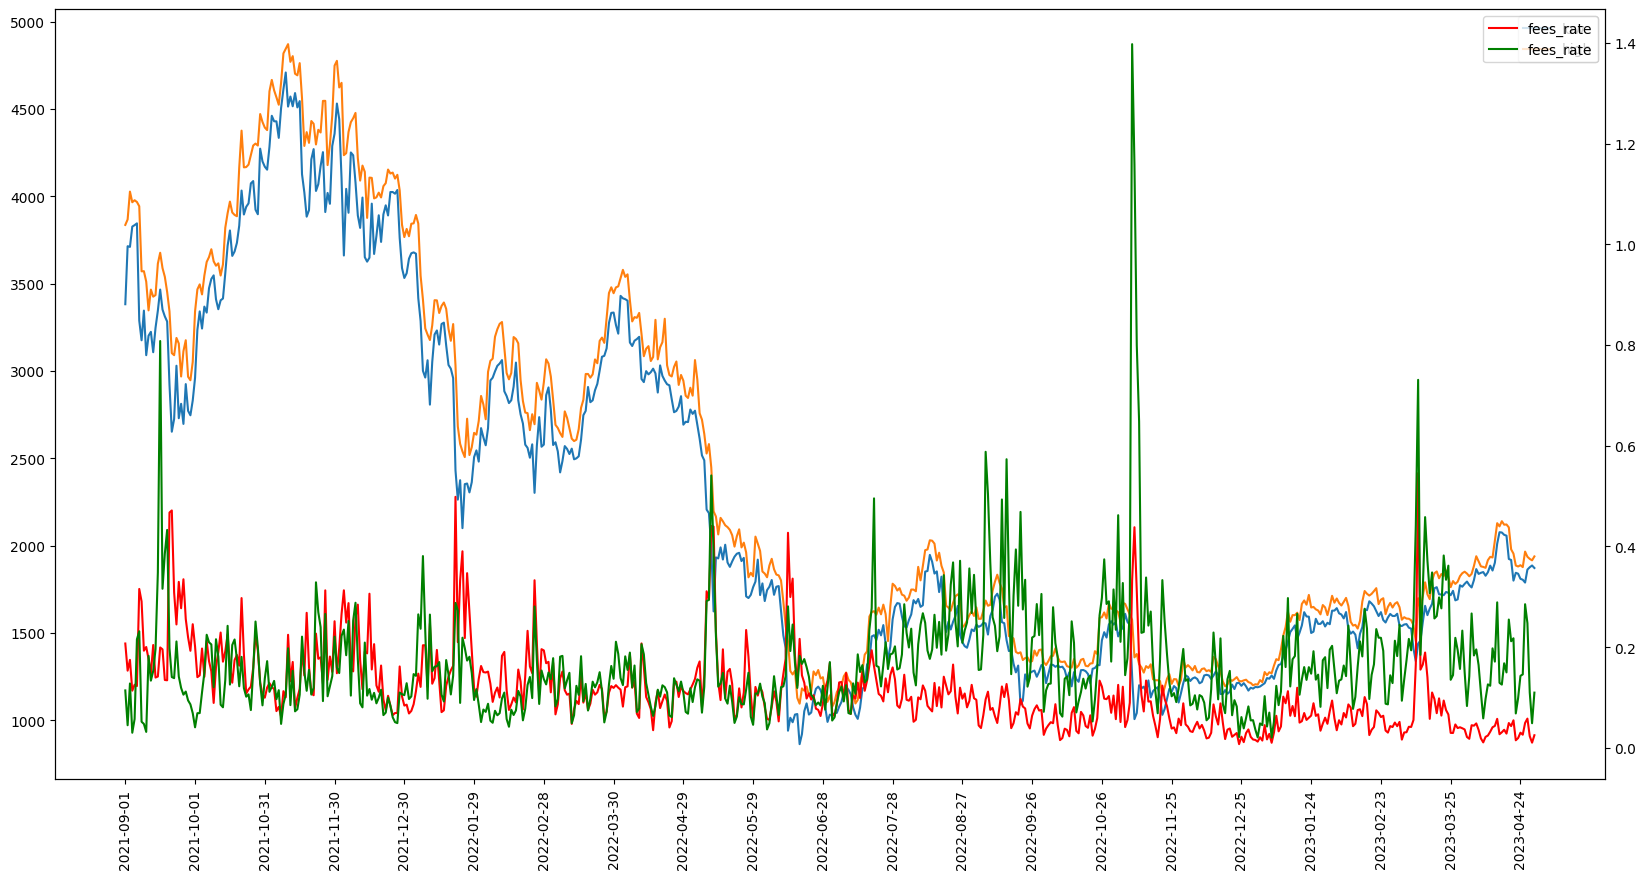

In [69]:
import matplotlib.pyplot as plt

def get_plot(analysis_df):
    plt.figure(figsize=(20, 10))
    plt.plot(analysis_df["date"], analysis_df["low"], label="low")
    plt.plot(analysis_df["date"], analysis_df["high"], label="high")
    plt.xticks(analysis_df["date"][::30], rotation=90)
    plt.legend()

    ax2 = plt.twinx()
    plt.plot(analysis_df["date"], analysis_df["eth_fees_rate"], label="fees_rate", color="red")
    plt.plot(analysis_df["date"], analysis_df["arb_fees_rate"], label="fees_rate", color="green")
    plt.xticks(analysis_df["date"][::30], rotation=90)
    plt.legend()
    return plt


plt = get_plot(analysis_df)
plt.show()

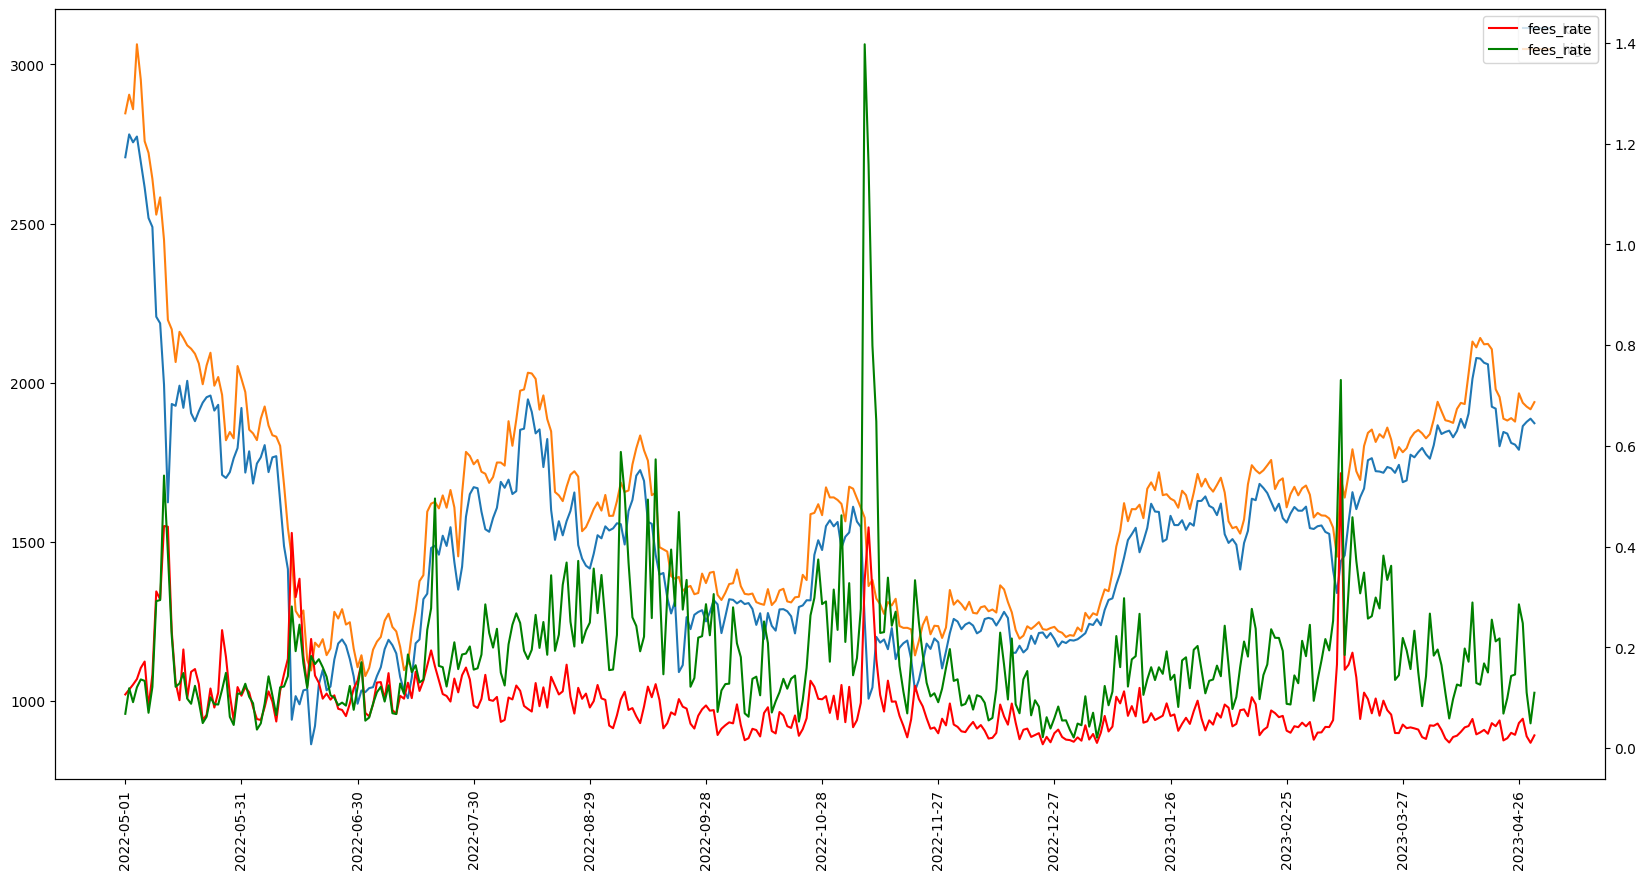

In [70]:
plt = get_plot(analysis_df[analysis_df["date"] > "2022-04-30"])
plt.show()

In [66]:
analysis_df.describe()

,arb_fees,arb_tvl,eth_fees,eth_tvl,high,low,eth_fees_rate,arb_fees_rate
count,607.00,607.00,607.00,607.00,607.00,607.00,607.00,607.00
mean,21651.11,13248054.39,281956.85,279752265.92,2384.53,2231.24,0.11,0.17
std,22335.17,10053656.50,169667.34,78276491.36,1062.93,1004.30,0.08,0.12
min,88.40,167475.65,23726.05,87802748.47,1078.29,863.90,0.01,0.02
25%,7744.10,7853327.80,171389.33,243931693.72,1567.50,1438.04,0.06,0.10
50%,14725.88,11598094.74,250190.74,283281322.54,1883.97,1789.17,0.10,0.14
75%,27449.37,16565633.39,347291.89,322738481.25,3195.91,3000.77,0.14,0.21
max,144209.50,59522967.00,1723070.23,492903505.62,4872.18,4709.89,0.55,1.40


In [71]:
analysis_df[analysis_df["date"] > "2022-12-31"].describe()

,arb_fees,arb_tvl,eth_fees,eth_tvl,high,low,eth_fees_rate,arb_fees_rate
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,49220.09,27598689.86,216926.93,382379442.61,1709.75,1628.82,0.06,0.18
std,29704.77,11356665.81,178744.15,48907561.72,201.14,197.53,0.06,0.10
min,3214.25,13530963.74,35573.15,315778068.68,1204.75,1189.72,0.01,0.02
25%,27288.35,18851423.49,128777.85,344310637.02,1606.06,1524.75,0.03,0.12
50%,42930.04,24461155.93,187863.16,364953644.33,1696.12,1611.76,0.05,0.16
75%,64802.93,34872012.62,251203.25,435643228.82,1845.00,1773.99,0.07,0.22
max,144209.50,59522967.00,1723070.23,492903505.62,2140.51,2077.54,0.55,0.73


In [82]:
# 历史上的 eth 价格波动是怎样的
# data is download from https://finance.yahoo.com/quote/ETH-USD/history?period1=1512086400&period2=1683244800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

eth_price_df = pd.read_csv("../data/eth_usd.csv")
eth_price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.64,329.45,307.06,320.88,320.88,893249984
1,2017-11-10,320.67,324.72,294.54,299.25,299.25,885985984
2,2017-11-11,298.59,319.45,298.19,314.68,314.68,842300992
3,2017-11-12,314.69,319.15,298.51,307.91,307.91,1613479936
4,2017-11-13,307.02,328.42,307.02,316.72,316.72,1041889984


In [83]:
eth_price_df.shape

(2004, 7)

In [84]:
eth_price_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1999,2023-05-01,1868.89,1886.21,1809.19,1831.95,1831.95,8625783201
2000,2023-05-02,1831.73,1879.76,1824.33,1870.79,1870.79,7536785767
2001,2023-05-03,1870.69,1915.50,1845.87,1904.65,1904.65,8306390869
2002,2023-05-04,1905.17,1915.87,1868.63,1877.70,1877.70,6578438233
2003,2023-05-05,1877.66,1907.64,1877.48,1898.29,1898.29,6779210240


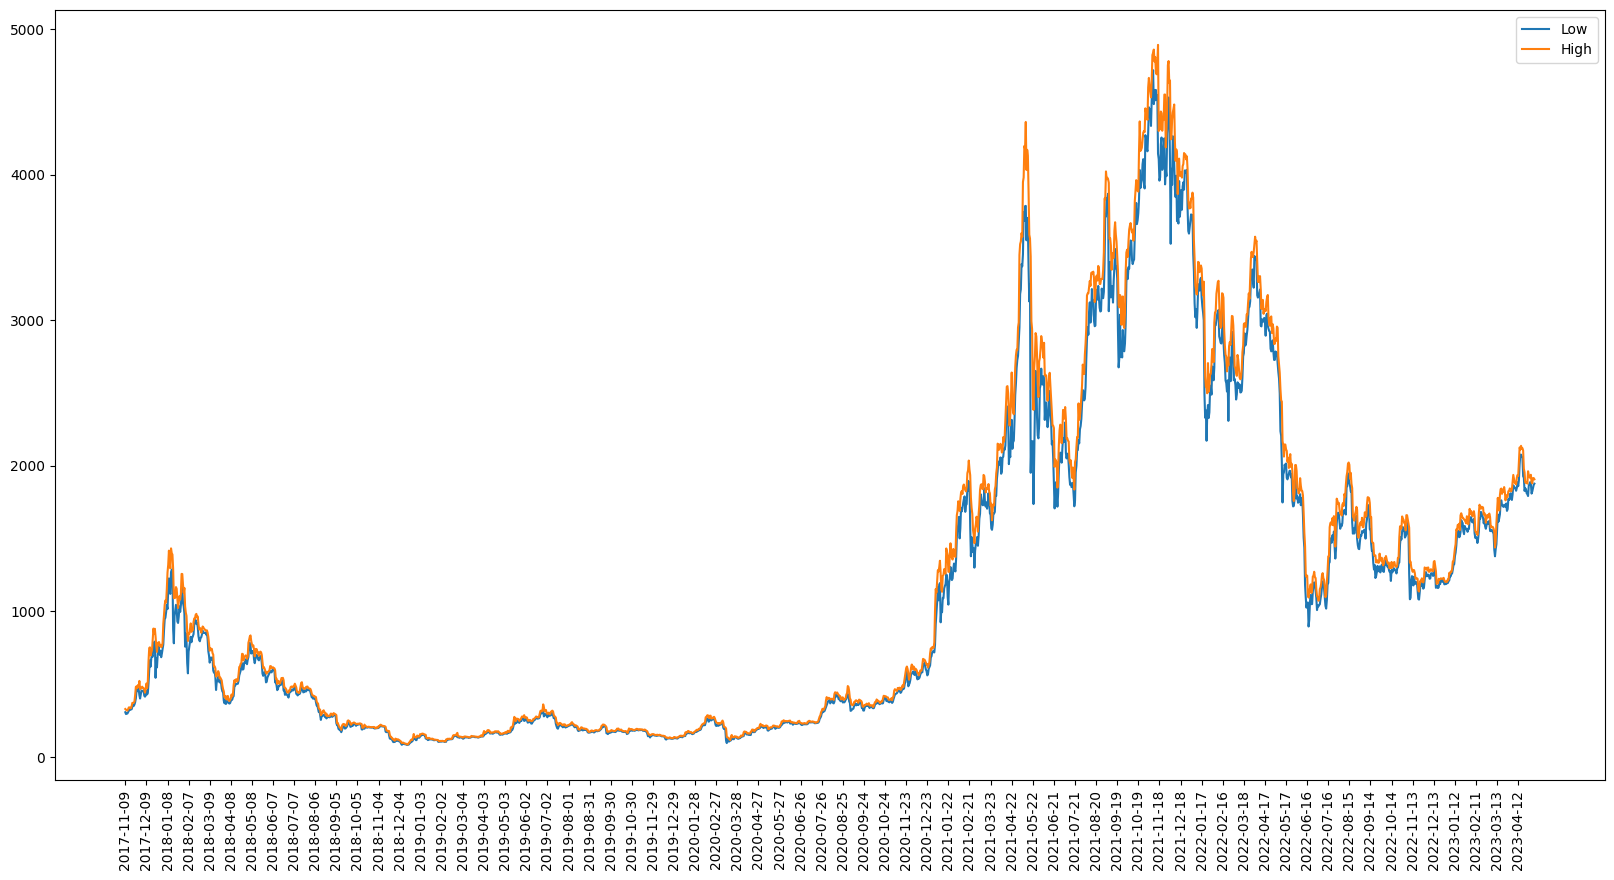

In [86]:
plt.figure(figsize=(20, 10))
plt.plot(eth_price_df["Date"], eth_price_df["Low"], label="Low")
plt.plot(eth_price_df["Date"], eth_price_df["High"], label="High")
plt.xticks(eth_price_df["Date"][::30], rotation=90)
plt.legend()
plt.show()

In [87]:
eth_price_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2004.00,2004.00,2004.00,2004.00,2004.00,2004.00
mean,1163.54,1199.81,1123.00,1164.11,1164.11,12627154088.38
std,1159.43,1194.36,1119.32,1158.94,1158.94,10523596401.87
min,84.28,85.34,82.83,84.31,84.31,621732992.00
25%,218.62,224.22,211.93,218.49,218.49,4845131279.25
50%,605.78,620.89,581.51,606.26,606.26,10165077797.00
75%,1792.24,1834.17,1729.77,1791.90,1791.90,17591418532.50
max,4810.07,4891.70,4718.04,4812.09,4812.09,84482912776.00


In [88]:
eth_price_df["Change_rate"] = (eth_price_df["Close"] - eth_price_df["Open"]) / eth_price_df["Open"] * 100
eth_price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Change_rate
0,2017-11-09,308.64,329.45,307.06,320.88,320.88,893249984,3.97
1,2017-11-10,320.67,324.72,294.54,299.25,299.25,885985984,-6.68
2,2017-11-11,298.59,319.45,298.19,314.68,314.68,842300992,5.39
3,2017-11-12,314.69,319.15,298.51,307.91,307.91,1613479936,-2.16
4,2017-11-13,307.02,328.42,307.02,316.72,316.72,1041889984,3.16


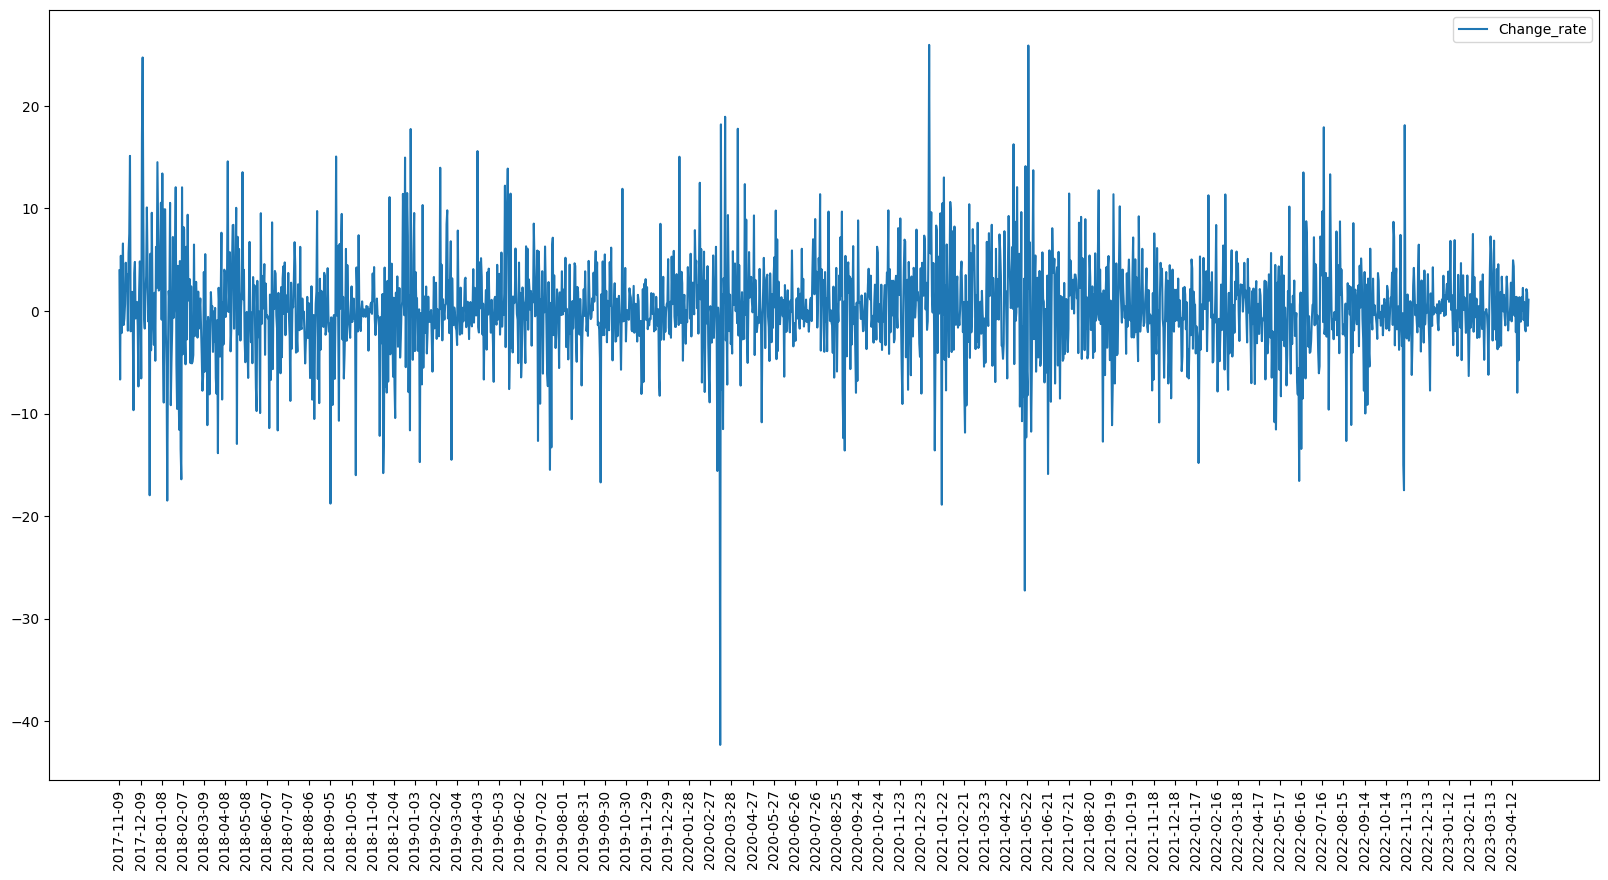

In [89]:
plt.figure(figsize=(20, 10))
plt.plot(eth_price_df["Date"], eth_price_df["Change_rate"], label="Change_rate")
plt.xticks(eth_price_df["Date"][::30], rotation=90)
plt.legend()
plt.show()

In [90]:
eth_price_df.describe()

,Open,High,Low,Close,Adj Close,Volume,Change_rate
count,2004.00,2004.00,2004.00,2004.00,2004.00,2004.00,2004.00
mean,1163.54,1199.81,1123.00,1164.11,1164.11,12627154088.38,0.20
std,1159.43,1194.36,1119.32,1158.94,1158.94,10523596401.87,4.95
min,84.28,85.34,82.83,84.31,84.31,621732992.00,-42.31
25%,218.62,224.22,211.93,218.49,218.49,4845131279.25,-2.08
50%,605.78,620.89,581.51,606.26,606.26,10165077797.00,0.10
75%,1792.24,1834.17,1729.77,1791.90,1791.90,17591418532.50,2.60
max,4810.07,4891.70,4718.04,4812.09,4812.09,84482912776.00,25.95


In [105]:
eth_price_df["Month"] = eth_price_df["Date"].apply(lambda x: x[:7])

month_df = eth_price_df.groupby("Month").agg({"High": "max", "Low": "min"}).reset_index()
month_df.tail()

,Month,High,Low
62,2023-01,1674.18,1192.89
63,2023-02,1732.80,1470.02
64,2023-03,1853.89,1378.53
65,2023-04,2137.45,1765.52
66,2023-05,1915.87,1809.19


In [106]:
month_df.tail(10)

,Month,High,Low
57,2022-08,2022.79,1427.73
58,2022-09,1784.50,1229.43
59,2022-10,1652.38,1209.28
60,2022-11,1661.33,1081.14
61,2022-12,1346.17,1160.38
62,2023-01,1674.18,1192.89
63,2023-02,1732.80,1470.02
64,2023-03,1853.89,1378.53
65,2023-04,2137.45,1765.52
66,2023-05,1915.87,1809.19


In [127]:
# get intersection distance of two list [high1, low1] and [high2, low2]
def get_intersection_distance(high1, low1, high2, low2):
    if high1 < low2 or high2 < low1:
        return 0
    else:
        return min(high1, high2) - max(low1, low2)

get_intersection_distance(80, 60, 100, 70)

10

In [130]:
def calculate_in_range_percent(month_high, month_low, day_high, day_low):
    if month_high < day_low or day_high < month_low:
        return 0

    high = min(month_high, day_high)
    low = max(month_low, day_low)
    return (high - low) / (day_high - day_low)


calculate_in_range_percent(100, 70, 80, 60)

0.5

In [107]:
# convert month_df to dict, key is Month, value is [High, Low]
month_dict = {}
for index, row in month_df.iterrows():
    month_dict[row["Month"]] = [row["High"], row["Low"]]
print(month_dict)

{'2017-11': [522.307007, 294.541992], '2017-12': [881.94397, 414.411011], '2018-01': [1432.880005, 742.004028], '2018-02': [1161.349976, 574.419006], '2018-03': [880.302002, 368.632996], '2018-04': [708.875, 363.804993], '2018-05': [835.057007, 512.552002], '2018-06': [624.513, 407.946991], '2018-07': [513.432983, 422.809998], '2018-08': [435.457001, 254.649994], '2018-09': [301.144012, 170.257004], '2018-10': [234.145004, 188.707001], '2018-11': [221.651993, 101.769997], '2018-12': [157.668701, 82.829887], '2019-01': [160.82489, 103.336464], '2019-02': [165.549622, 102.934563], '2019-03': [149.613235, 125.402702], '2019-04': [184.377853, 140.737564], '2019-05': [287.20163, 159.660217], '2019-06': [361.398682, 229.257431], '2019-07': [318.223114, 193.990417], '2019-08': [239.115906, 167.071411], '2019-09': [222.871689, 157.130325], '2019-10': [195.942505, 157.463425], '2019-11': [193.547256, 133.802338], '2019-12': [153.155396, 119.78006], '2020-01': [186.260483, 126.490021], '2020-02'

In [109]:
# convert eth_price_df to list, value is [Date, High, Low, Volume]
eth_price_list = []
for index, row in eth_price_df[eth_price_df["Date"] > "2017-12"].iterrows():
    eth_price_list.append([row["Date"], row["High"], row["Low"], row["Volume"]])
print(eth_price_list[0])

['2017-12-01', 472.609009, 428.312012, 1247879936]


In [112]:
# get past month date str list, current_month is like "2021-09", param past_month_cnt is like 1, 2, 3
from dateutil.relativedelta import relativedelta


def get_past_month_date_str_list(current_month, past_month_cnt=1):
    current_month_date = datetime.strptime(current_month, "%Y-%m")
    past_month_date_str_list = []
    for i in range(past_month_cnt):
        past_month_date_str_list.append((current_month_date - relativedelta(months=i+1)).strftime("%Y-%m"))
    return past_month_date_str_list


get_past_month_date_str_list("2021-09", 3)

['2021-08', '2021-07', '2021-06']

In [144]:
def get_past_month_high_low(current_month, past_month_cnt=1):
    past_month_list = get_past_month_date_str_list(current_month, past_month_cnt)
    price_list = []
    for month in past_month_list:
        if month in month_dict:
            price_list += month_dict[month]
    return [max(price_list), min(price_list)]

get_past_month_high_low("2023-05", 2)

[2137.445068, 1378.525391]

In [119]:
len(eth_price_list)

1982

In [149]:
def calc_with_month_high_low(month_count=1):
    date_percent_list = list()
    for i,data in enumerate(eth_price_list):
        date = data[0]
        current_month = date[:7]
        high = data[1]
        low = data[2]
        past_month_high, past_month_low = get_past_month_high_low(current_month, month_count)
        in_range_percent = calculate_in_range_percent(past_month_high, past_month_low, high, low)
        date_percent_list.append([date, current_month, high, low, past_month_high, past_month_low, in_range_percent])
        # if i % 20 == 0:
        #     print(date, high, low, past_month_high, past_month_low, in_range_percent)
    return date_percent_list


date_percent_list = calc_with_month_high_low(1)
print(len(date_percent_list))

1982


In [151]:
# convert data_percent_list to df
date_percent_list = calc_with_month_high_low(1)
date_percent_df = pd.DataFrame(date_percent_list, columns=["Date", "Month", "High", "Low", "Past_month_high", "Past_month_low", "In_range_percent"])
month_percent_df = date_percent_df.groupby("Month").agg({"In_range_percent": "mean"}).reset_index()
month_percent_df.describe()

,In_range_percent
count,66.00
mean,0.60
std,0.34
min,0.00
25%,0.34
50%,0.62
75%,0.97
max,1.00


In [153]:
month_percent_df[(month_percent_df["Month"] > "2021-08") & (month_percent_df["Month"] < "2023-05")].describe()

,In_range_percent
count,20.00
mean,0.64
std,0.28
min,0.16
25%,0.45
50%,0.68
75%,0.88
max,1.00


In [154]:
date_percent_list = calc_with_month_high_low(2)
date_percent_df = pd.DataFrame(date_percent_list, columns=["Date", "Month", "High", "Low", "Past_month_high", "Past_month_low", "In_range_percent"])
month_percent_df = date_percent_df.groupby("Month").agg({"In_range_percent": "mean"}).reset_index()
month_percent_df.describe()

,In_range_percent
count,66.00
mean,0.69
std,0.34
min,0.00
25%,0.49
50%,0.80
75%,1.00
max,1.00


In [155]:
month_percent_df[(month_percent_df["Month"] > "2021-08") & (month_percent_df["Month"] < "2023-05")].describe()

,In_range_percent
count,20.00
mean,0.73
std,0.30
min,0.16
25%,0.55
50%,0.86
75%,1.00
max,1.00


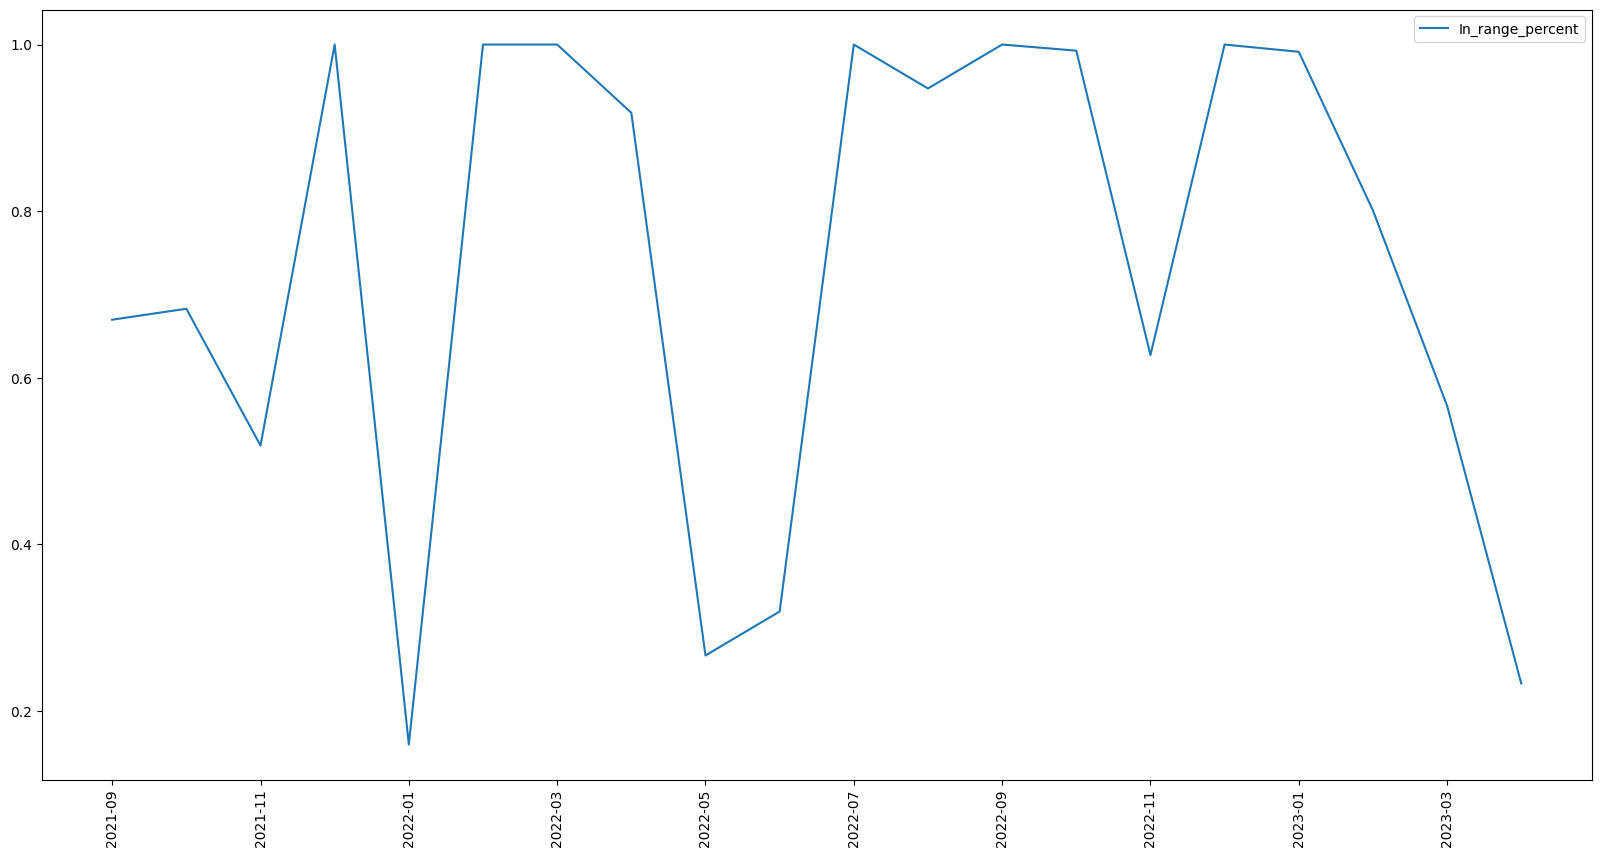

In [156]:
# plot month_percent_df, x is Month, Y is In_range_percent (2 months)
filter_df = month_percent_df[(month_percent_df["Month"] > "2021-08") & (month_percent_df["Month"] < "2023-05")]

plt.figure(figsize=(20, 10))
plt.plot(filter_df["Month"], filter_df["In_range_percent"], label="In_range_percent")
plt.xticks(filter_df["Month"][::2], rotation=90)
plt.legend()
plt.show()

In [157]:
filter_df.head(20)

,Month,In_range_percent
45,2021-09,0.67
46,2021-10,0.68
47,2021-11,0.52
48,2021-12,1.00
49,2022-01,0.16
50,2022-02,1.00
51,2022-03,1.00
52,2022-04,0.92
53,2022-05,0.27
54,2022-06,0.32


In [158]:
date_percent_list = calc_with_month_high_low(3)
date_percent_df = pd.DataFrame(date_percent_list, columns=["Date", "Month", "High", "Low", "Past_month_high", "Past_month_low", "In_range_percent"])
month_percent_df = date_percent_df.groupby("Month").agg({"In_range_percent": "mean"}).reset_index()
month_percent_df.describe()

,In_range_percent
count,66.00
mean,0.73
std,0.33
min,0.00
25%,0.55
50%,0.95
75%,1.00
max,1.00


In [159]:
month_percent_df[(month_percent_df["Month"] > "2021-08") & (month_percent_df["Month"] < "2023-05")].describe()

,In_range_percent
count,20.00
mean,0.77
std,0.27
min,0.23
25%,0.61
50%,0.90
75%,1.00
max,1.00


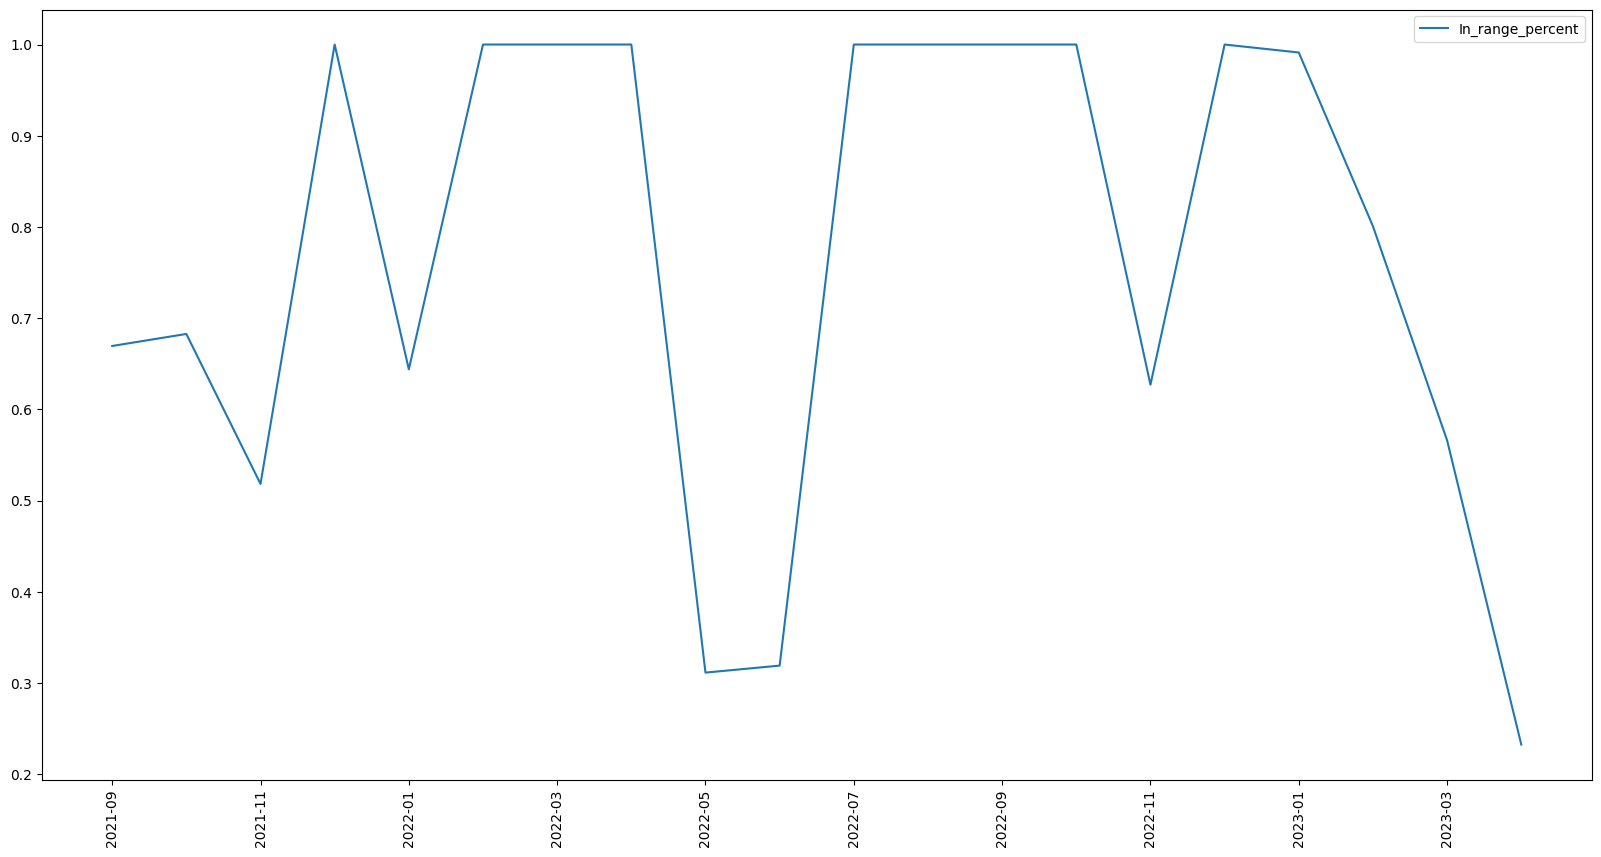

In [160]:
# plot month_percent_df, x is Month, Y is In_range_percent (2 months)
filter_df = month_percent_df[(month_percent_df["Month"] > "2021-08") & (month_percent_df["Month"] < "2023-05")]

plt.figure(figsize=(20, 10))
plt.plot(filter_df["Month"], filter_df["In_range_percent"], label="In_range_percent")
plt.xticks(filter_df["Month"][::2], rotation=90)
plt.legend()
plt.show()

In [161]:
# 添加标准差进行考虑 —— 过去几个月的高点无法预测未来高点，价格分布是大部分不怎么动，但会出现短时大幅波动（期权押注的多空策略）
month_df = eth_price_df.groupby("Month").agg({"High": ["max", "std", "mean"], "Low": ["min", "mean", "std"]}).reset_index()
month_df.tail()

Month    High                    Low               
                max    std    mean     min    mean    std
62  2023-01 1674.18 167.62 1486.60 1192.89 1434.77 150.83
63  2023-02 1732.80  58.90 1654.28 1470.02 1595.18  58.37
64  2023-03 1853.89 121.71 1712.65 1378.53 1635.39 114.12
65  2023-04 2137.45  95.35 1951.56 1765.52 1881.88  88.96
66  2023-05 1915.87  16.92 1901.00 1809.19 1845.10  28.82

In [168]:
def compare_range(std_cnt=1):
    cmp_list = list()
    for index, row in month_df.iterrows():
        month = str(row["Month"])
        high = float(row["High"]["max"])
        high_std = float(row["High"]["std"])
        high_mean = float(row["High"]["mean"])
        new_high = high_mean + high_std * std_cnt

        low = float(row["Low"]["min"])
        low_std = float(row["Low"]["std"])
        low_mean = float(row["Low"]["mean"])
        new_low = low_mean - low_std * std_cnt

        cmp_result = 0
        if new_high > high and new_low < low:
            cmp_result = 1
        elif (new_high > high and new_low > low) or (new_high < high and new_low < low):
            cmp_result = 0.5
        print(month, new_high, new_low, high, low, cmp_result)
        cmp_list.append(cmp_result)
    return cmp_list


cmp_result = compare_range(2)
print(len(cmp_result))

    2017-11
Name: 0, dtype: object 533.1110652448878 244.93723019071973 522.307007 294.541992 1
    2017-12
Name: 1, dtype: object 969.2122838613545 329.9309085358898 881.94397 414.411011 1
    2018-01
Name: 2, dtype: object 1469.5202270131936 743.0036465871365 1432.880005 742.004028 0.5
    2018-02
Name: 3, dtype: object 1063.381036034338 653.3783664190536 1161.349976 574.419006 0
    2018-03
Name: 4, dtype: object 953.2044172563939 305.4727466842427 880.302002 368.632996 1
    2018-04
Name: 5, dtype: object 770.2912060382864 281.49071354117257 708.875 363.804993 1
    2018-05
Name: 6, dtype: object 856.2736971956225 505.54624519418314 835.057007 512.552002 1
    2018-06
Name: 7, dtype: object 656.6894477876904 380.21716961792924 624.513 407.946991 1
    2018-07
Name: 8, dtype: object 510.3816309190199 421.3002334560874 513.432983 422.809998 0.5
    2018-08
Name: 9, dtype: object 441.9162776856708 208.51538903616358 435.457001 254.649994 1
    2018-09
Name: 10, dtype: object 297.23983

In [169]:
# get cmp_result average and 25%,50%,75%,min,max
import numpy as np

data = np.array(cmp_result)
data.mean()

0.7761194029850746

In [ ]:
# 最终决定不采取这个基于过去几个月的最高值或平均值+几倍标准差的方案，因为这个方案是基于过去的数据，虽然在大多数历史时期是有效的，但是在当下这几个月已经失效，或者给出的区间范围过大
# 另外考虑费率高时往往是价格波动大的时候，还是结合费率外加高抛低吸的策略进行